In [1]:
scenario = 'actual_vmf3_grads'

In [2]:
import pandas as pd
import numpy as np
# from google.colab import drive
import os
import glob
from datetime import timedelta, datetime

# Função para ler o arquivo de coordenadas das estações RBMC
def read_rbmc_coordinates(file_path):
    columns = ['YearDay', 'Date', 'StationID', 'CoordSystem', 'StationName', 'StationCode',
               'X', 'Y', 'Z', 'StdX', 'StdY', 'StdZ']

    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    df['Date'] = pd.to_datetime(df['Date'])
    df['X'] = df['X'].astype(float)
    df['Y'] = df['Y'].astype(float)
    df['Z'] = df['Z'].astype(float)
    df['StdX'] = df['StdX'].astype(float)
    df['StdY'] = df['StdY'].astype(float)
    df['StdZ'] = df['StdZ'].astype(float)

    return df

# Função para extrair os dados de processamento GNSS
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_lines = [line.strip() for line in lines if line[0].isdigit()]

    timestamps = []
    x_coords = []
    y_coords = []
    z_coords = []

    for line in data_lines:
        parts = line.split()
        timestamp = parts[0] + ' ' + parts[1]
        x = float(parts[2])
        y = float(parts[3])
        z = float(parts[4])

        timestamps.append(timestamp)
        x_coords.append(x)
        y_coords.append(y)
        z_coords.append(z)

    data = pd.DataFrame({
        'Timestamp': pd.to_datetime(timestamps),
        'X': x_coords,
        'Y': y_coords,
        'Z': z_coords
    })

    return data

# Função para calcular o RMSE
def calculate_rmse(predictions, true_values):
    return np.sqrt(np.mean((predictions - true_values) ** 2))

def doy_year_to_date(doy, year):
  """Converts day of year (DOY) and year to a date object.

  Args:
    doy: The day of year (1-366).
    year: The year (e.g., 2023).

  Returns:
    A datetime object representing the date.
  """
  date = datetime(year, 1, 1) + timedelta(days=doy - 1)
  return date

def get_closest_backward_date(query_date, datearray):
  """Finds the closest date in datearray that is less than or equal to query_date.

  Args:
    query_date: A pandas Timestamp object representing the query date.
    datearray: A pandas DatetimeIndex or Series representing the array of dates.

  Returns:
    A pandas Timestamp object representing the closest backward date, or None if
    no such date is found.
  """
  # Filter dates less than or equal to query_date
  valid_dates = datearray[datearray <= query_date]

  # If no valid dates are found, return None
  if valid_dates.empty:
    return None

  # Return the last (closest) valid date
  return valid_dates[-1]

def get_closest_date(query_date, datearray):
  """Finds the closest date in datearray to query_date.

  Args:
    query_date: A pandas Timestamp object representing the query date.
    datearray: A pandas DatetimeIndex or Series representing the array of dates.

  Returns:
    A pandas Timestamp object representing the closest date.
  """
  # Calculate absolute time differences
  time_diffs = abs(datearray - query_date)

  # Find the index of the minimum time difference
  closest_index = time_diffs.argmin()

  # Return the date at the closest index
  return datearray[closest_index]

In [3]:
# # Monta o Google Drive para acessar os arquivos
# drive.mount('/content/drive')

In [4]:
# Meses e estações RBMC
meses = ['VERAO', 'INVERNO']
estacoes_rbmc = ['BRAZ', 'CUIB', 'UFPR', 'NAUS', 'POAL', 'PERC', 'ONRJ', 'SSA1', 'SAGA', 'POLI']

all_scenarios = ['orig','orig_nograd','mod_vmf3_grads_no_deriv',"vmf3_grads_lat_14_04","actual_vmf3_grads"]

charts_path = 'charts'

# Caminho base dos arquivos
# base_input_path = r'C:\Users\kaue\ufpr.br\Lais Thuany Cardoso Theodoro - VMF3\saidas'
# base_path = f'/content/drive/My Drive/VMF3/dados/{scenario}/'
base_input_path = '/home/gnss_data/saidas'
base_path = os.path.join(base_input_path,scenario)


# Caminho dos arquivos de coordenadas das estações
file_path_rbmc = 'Coordenadas_estacoes.txt'

# Lê os dados das coordenadas das estações RBMC
df_rbmc = read_rbmc_coordinates(file_path_rbmc)

# declarando o ano:
ano = 2020

# Define a data inicial e final para análise
# data_inicial = {'VERAO' : pd.Timestamp('2020-01-01'), "INVERNO" : pd.Timestamp('2020-06-01')}
# data_final = {'VERAO' : pd.Timestamp('2020-01-31'), "INVERNO" : pd.Timestamp('2020-07-31')}

/tmp/ipykernel_229107/4269147699.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)


In [5]:
for sc in all_scenarios:
    os.makedirs(os.path.join(charts_path, sc), exist_ok=True)
    os.makedirs(os.path.join('saidas', sc), exist_ok=True)
    
sc_outpath = os.path.join('saidas',scenario)
sc_charts_outpath = os.path.join(charts_path,scenario)

In [6]:
# CÉLULA PRA TESTAR A INTEGRIDADE DOS DADOS

for mes in meses:
    for estacao in estacoes_rbmc:
      file_path_gnss = os.path.join(base_path, mes, estacao, 'pos')

      filelist = os.listdir(file_path_gnss)
      total_files_pos_files = [f for f in filelist if not '.stat' in f]
      total_stat_files = [f for f in filelist if '.stat' in f]

      print(mes,estacao,len(total_files_pos_files),len(total_stat_files),len(filelist))

VERAO BRAZ 31 0 31
VERAO CUIB 31 0 31
VERAO UFPR 31 0 31
VERAO NAUS 31 0 31
VERAO POAL 31 0 31
VERAO PERC 31 0 31
VERAO ONRJ 31 0 31
VERAO SSA1 31 0 31
VERAO SAGA 31 0 31
VERAO POLI 31 0 31
INVERNO BRAZ 31 0 31
INVERNO CUIB 31 0 31
INVERNO UFPR 31 0 31
INVERNO NAUS 31 0 31
INVERNO POAL 31 0 31
INVERNO PERC 31 0 31
INVERNO ONRJ 31 0 31
INVERNO SSA1 31 0 31
INVERNO SAGA 31 0 31
INVERNO POLI 31 0 31


In [7]:
unique_week_ref_dates = df_rbmc['Date'].unique()

unique_week_ref_dates

<DatetimeArray>
['2020-01-01 00:00:00', '2020-01-08 00:00:00', '2020-01-15 00:00:00',
 '2020-01-22 00:00:00', '2020-01-29 00:00:00', '2020-07-01 00:00:00',
 '2020-07-08 00:00:00', '2020-07-15 00:00:00', '2020-07-22 00:00:00',
 '2020-07-29 00:00:00']
Length: 10, dtype: datetime64[ns]

In [8]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import timedelta, datetime

# Inicializa a lista para armazenar os resultados
results = []

# Itera sobre cada mês e estação RBMC
for mes in meses:
    for estacao in estacoes_rbmc:
        # Caminho dos arquivos de processamento GNSS
        file_path_gnss = os.path.join(base_path, mes, estacao, 'pos')

        # Encontre todos os arquivos .pos
        gnss_files = glob.glob(os.path.join(file_path_gnss, '*.pos'))

        for filepath in gnss_files:
            try:
                # Extrair o "day of year"
                doy = int(filepath.split('_')[-2][-4:-1])

                # Transformar DOY + ano em data
                doy_as_date = doy_year_to_date(doy, ano)

                # Data de referência semanal mais próxima
                ref_date = get_closest_date(doy_as_date, unique_week_ref_dates)

                # Coordenadas da estação
                station_coordinates = df_rbmc[
                    (df_rbmc['StationName'] == estacao) & (df_rbmc['Date'] == ref_date)
                ][['X', 'Y', 'Z']].values

                if station_coordinates.size == 0:
                    print(f"Sem coordenadas para {estacao} em {ref_date}. Pulando...")
                    continue

                # Processando o arquivo de resultados
                gnss_data = extract_data(filepath)

                # Calcula o RMSE para cada coordenada (X, Y, Z)
                rmse_x = calculate_rmse(gnss_data['X'].values, station_coordinates[0, 0])
                rmse_y = calculate_rmse(gnss_data['Y'].values, station_coordinates[0, 1])
                rmse_z = calculate_rmse(gnss_data['Z'].values, station_coordinates[0, 2])

                # Adiciona os resultados à lista
                results.append({
                    'Estacao': estacao,
                    'Periodo': mes,
                    'DOY': doy,
                    'DataReferencia': ref_date,
                    'RMSE_X': rmse_x,
                    'RMSE_Y': rmse_y,
                    'RMSE_Z': rmse_z
                })

            except Exception as e:
                print(f"Erro ao processar arquivo {filepath}: {e}")

# Cria um DataFrame com os resultados
df_results = pd.DataFrame(results)

# Exibe o resumo agrupado por estação e período
summary = df_results.groupby(['Estacao', 'Periodo']).mean(numeric_only=True)
print(summary)

# Salva os resultados em um arquivo CSV
# output_file = f'saidas/{scenario}/rmse_summary.csv'
output_file = os.path.join(sc_outpath,'rmse_summary.csv')
df_results.to_csv(output_file, index=False)
print(f"Resumo salvo em {output_file}")


actual_summary_path = os.path.join(sc_outpath,'rmse_general_summary.csv')
summary.to_csv(actual_summary_path, index=False)


                   DOY    RMSE_X    RMSE_Y    RMSE_Z
Estacao Periodo                                     
BRAZ    INVERNO  198.0  0.214718  0.269897  0.126470
        VERAO     16.0  0.254026  0.287362  0.174376
CUIB    INVERNO  198.0  0.216206  0.393711  0.154700
        VERAO     16.0  0.190922  0.342794  0.131207
NAUS    INVERNO  198.0  0.158510  0.253902  0.054891
        VERAO     16.0  0.124365  0.268226  0.047261
ONRJ    INVERNO  198.0  0.316708  0.390665  0.251579
        VERAO     16.0  0.362939  0.407357  0.259130
PERC    INVERNO  198.0  0.357852  0.279501  0.116290
        VERAO     16.0  0.350478  0.270223  0.103986
POAL    INVERNO  198.0  0.154602  0.333121  0.208788
        VERAO     16.0  0.163707  0.296985  0.199144
POLI    INVERNO  198.0  0.250206  0.286641  0.188001
        VERAO     16.0  0.261821  0.300917  0.213028
SAGA    INVERNO  198.0  0.150014  0.365345  0.068313
        VERAO     16.0  0.143894  0.292294  0.052993
SSA1    INVERNO  198.0  0.286724  0.291961  0.

In [9]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime, timedelta

# Função para calcular o RMSE
def calculate_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2))

# Caminho base para os arquivos
# base_path = f'/content/drive/My Drive/VMF3/dados/{scenario}'

# Configurações específicas
estacao = 'SAGA'
data_alvo = datetime(2020, 1, 6)

# Caminho do arquivo de processamento GNSS para a estação SAGA
file_path_gnss = os.path.join(base_path, 'january', estacao, 'pos')

# Encontra todos os arquivos .pos na pasta
gnss_files = glob.glob(os.path.join(file_path_gnss, '*.pos'))

# Inicializa lista para armazenar os resultados
results = []

# Itera pelos arquivos de processamento GNSS
for filepath in gnss_files:
    try:
        # Extrair o "day of year" (DOY)
        doy = int(filepath.split('_')[-2][-4:-1])

        # Converte DOY para data
        data_arquivo = datetime(2020, 1, 1) + timedelta(days=doy - 1)

        # Verifica se é a data alvo
        if data_arquivo == data_alvo:
            print(f"Processando arquivo {filepath} para o dia {data_alvo.strftime('%Y-%m-%d')}")

            # Função para extrair os dados GNSS (exemplo genérico, ajuste conforme formato real)
            gnss_data = pd.read_csv(filepath, delim_whitespace=True)

            # Substitua as colunas abaixo pelos nomes corretos do seu arquivo .pos
            x_values = gnss_data['X'].values
            y_values = gnss_data['Y'].values
            z_values = gnss_data['Z'].values

            # Coordenadas oficiais da estação SAGA
            station_coordinates = {
                'X': -2809455.383,
                'Y': -4161065.669,
                'Z': -3895878.728
            }

            # Calcula o RMSE para cada coordenada
            rmse_x = calculate_rmse(x_values, station_coordinates['X'])
            rmse_y = calculate_rmse(y_values, station_coordinates['Y'])
            rmse_z = calculate_rmse(z_values, station_coordinates['Z'])

            # Adiciona os resultados à lista
            results.append({
                'Estacao': estacao,
                'Data': data_alvo.strftime('%Y-%m-%d'),
                'RMSE_X': rmse_x,
                'RMSE_Y': rmse_y,
                'RMSE_Z': rmse_z
            })

            # Exibe os valores de RMSE no terminal
            print(f"RMSE para a estação {estacao} no dia {data_alvo.strftime('%Y-%m-%d')}:")
            print(f"  RMSE_X: {rmse_x:.4f}")
            print(f"  RMSE_Y: {rmse_y:.4f}")
            print(f"  RMSE_Z: {rmse_z:.4f}")

    except Exception as e:
        print(f"Erro ao processar arquivo {filepath}: {e}")

# Converte resultados para um DataFrame
df_results = pd.DataFrame(results)

# Salva os resultados em um arquivo CSV
output_file = os.path.join(base_path, 'rmse_saga_2020-01-06.csv')
df_results.to_csv(output_file, index=False)

print("\nProcessamento concluído.")
if not df_results.empty:
    print(f"Resultados salvos em: {output_file}")
# Cria um DataFrame com os resultados
df_results = pd.DataFrame(results)

print(df_results)


Processamento concluído.
Empty DataFrame
Columns: []
Index: []


In [10]:
import pandas as pd

# Caminho para o arquivo previamente gerado
# output_file = f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_summary.csv'
output_file = os.path.join(sc_outpath,'rmse_summary.csv')

# Verifica se o arquivo existe
if os.path.exists(output_file):
    # Carrega o arquivo CSV como DataFrame
    df_results = pd.read_csv(output_file)
    print("Arquivo carregado com sucesso!")
else:
    print(f"O arquivo {output_file} não foi encontrado. É necessário executar o processamento novamente.")


Arquivo carregado com sucesso!


In [11]:
# Filtra os dados para a estação SAGA no período VERÃO
df_saga_verao = df_results[(df_results['Estacao'] == 'SAGA') & (df_results['Periodo'] == 'INVERNO')]

# Verifica as colunas de RMSE
print(df_saga_verao[['DOY', 'RMSE_X', 'RMSE_Y', 'RMSE_Z']])

# Função para detectar outliers usando o IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifica os outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detecta outliers para cada coordenada (X, Y, Z)
outliers_x = detect_outliers(df_saga_verao, 'RMSE_X')
outliers_y = detect_outliers(df_saga_verao, 'RMSE_Y')
outliers_z = detect_outliers(df_saga_verao, 'RMSE_Z')

# Exibe os outliers encontrados para cada coordenada
print("Outliers para RMSE_X:")
print(outliers_x[['DOY', 'RMSE_X']])

print("Outliers para RMSE_Y:")
print(outliers_y[['DOY', 'RMSE_Y']])

print("Outliers para RMSE_Z:")
print(outliers_z[['DOY', 'RMSE_Z']])


     DOY    RMSE_X    RMSE_Y    RMSE_Z
558  207  0.081318  0.242934  0.038253
559  210  0.102493  0.285000  0.040646
560  183  0.080684  0.203393  0.046391
561  203  0.070124  0.215109  0.059862
562  186  0.084887  0.225839  0.056002
563  184  0.074475  0.247579  0.049388
564  189  0.088500  0.192952  0.042715
565  201  0.092900  0.248400  0.044891
566  197  0.092581  0.225176  0.046971
567  187  0.117838  0.252598  0.043724
568  188  0.093393  0.252847  0.049840
569  185  0.083099  0.226365  0.045738
570  202  0.087676  0.250048  0.051784
571  198  0.087157  0.230647  0.044407
572  199  0.081301  0.227410  0.051606
573  209  0.064595  0.219447  0.041654
574  193  0.079875  0.222278  0.044600
575  206  0.284940  0.360011  0.173479
576  200  0.078432  0.236856  0.046698
577  211  0.093724  0.259111  0.047524
578  192  0.088080  0.217043  0.046627
579  212  0.097271  0.267754  0.036647
580  191  0.105273  0.294978  0.049510
581  194  0.088304  0.241805  0.051675
582  190  0.082542  0.217

Histograma salvo em: charts/actual_vmf3_grads/rmse_histogram_janeiro.png


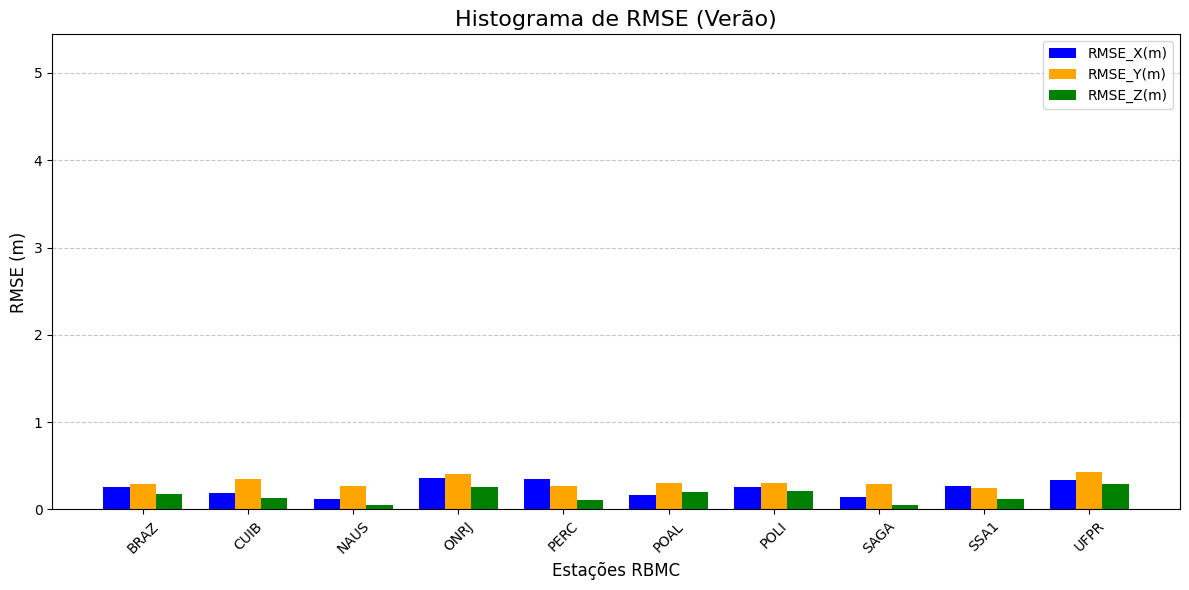

Histograma salvo em: charts/actual_vmf3_grads/rmse_histogram_julho.png


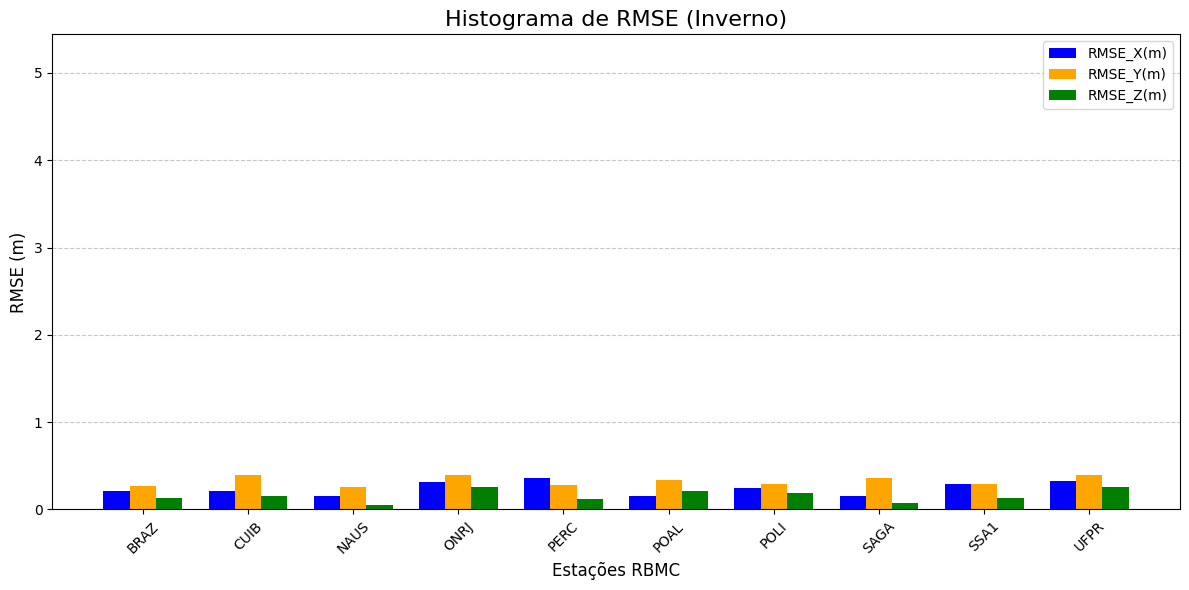

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Configurações para os histogramas
def plot_histograms(data, period, title, save_path, ymax):
    # Estações RBMC
    stations = np.sort(data['Estacao'].unique())  # Ordena as estações em ordem alfabética

    # Define o índice das estações
    x = np.arange(len(stations))

    # Largura das colunas
    width = 0.25

    # Valores RMSE para cada coordenada, ordenados pelas estações
    rmse_x = [data[data['Estacao'] == station]['RMSE_X'].mean() for station in stations]
    rmse_y = [data[data['Estacao'] == station]['RMSE_Y'].mean() for station in stations]
    rmse_z = [data[data['Estacao'] == station]['RMSE_Z'].mean() for station in stations]

    # Criação do gráfico
    fig, ax = plt.subplots(figsize=(12, 6))

    # Barras para cada RMSE
    ax.bar(x - width, rmse_x, width, label='RMSE_X(m)', color='blue')
    ax.bar(x, rmse_y, width, label='RMSE_Y(m)', color='orange')
    ax.bar(x + width, rmse_z, width, label='RMSE_Z(m)', color='green')

    # Configuração dos rótulos e título
    ax.set_xlabel('Estações RBMC', fontsize=12)
    ax.set_ylabel('RMSE (m)', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(stations, rotation=45, fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Define o mesmo limite no eixo Y para todos os gráficos
    ax.set_ylim(0, ymax)

    # Ajusta layout
    plt.tight_layout()

    # Salva a figura
    plt.savefig(save_path)
    print(f"Histograma salvo em: {save_path}")
    plt.show()

# Filtra os dados para os períodos VERÃO (janeiro) e INVERNO (julho)
data_verao = df_results[df_results['Periodo'] == 'VERAO']
data_inverno = df_results[df_results['Periodo'] == 'INVERNO']

# Calcula o valor máximo global de RMSE
rmse_max = max(
    data_verao[['RMSE_X', 'RMSE_Y', 'RMSE_Z']].max().max(),
    data_inverno[['RMSE_X', 'RMSE_Y', 'RMSE_Z']].max().max()
)

# Gera o histograma para janeiro (VERÃO)
plot_histograms(
    data=data_verao,
    period='VERAO',
    title='Histograma de RMSE (Verão)',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_janeiro.png',
    save_path = os.path.join(sc_charts_outpath,'rmse_histogram_janeiro.png'),
    ymax=rmse_max
)

# Gera o histograma para julho (INVERNO)
plot_histograms(
    data=data_inverno,
    period='INVERNO',
    title='Histograma de RMSE (Inverno)',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_julho.png',
    save_path = os.path.join(sc_charts_outpath,'rmse_histogram_julho.png'),
    ymax=rmse_max
)


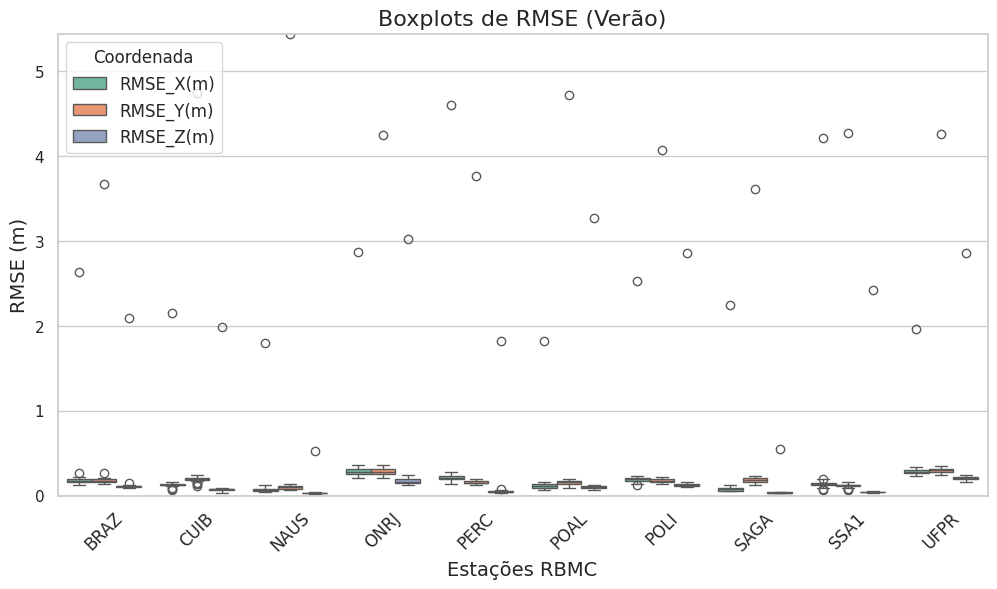

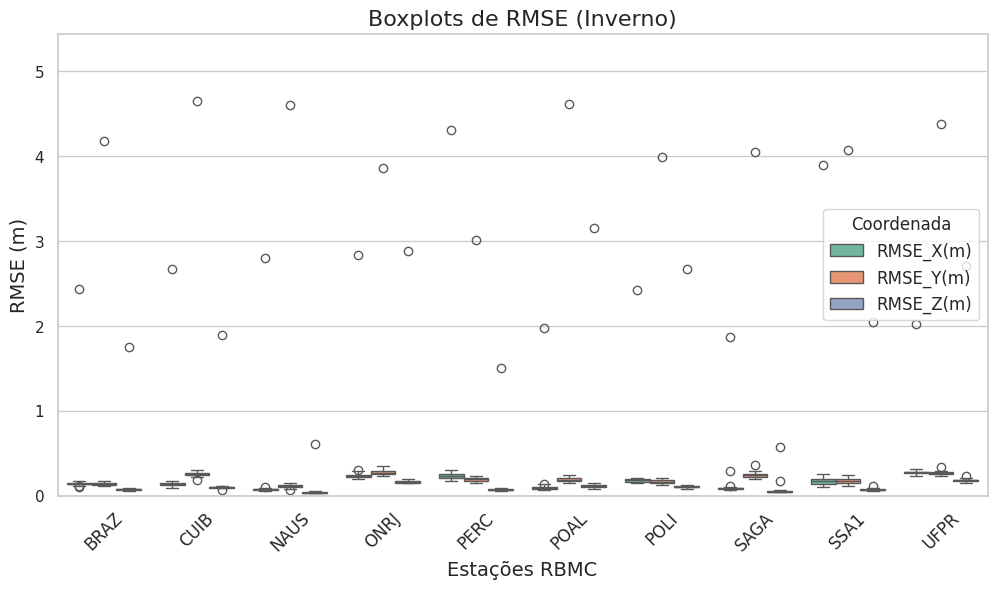

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações gerais de estilo
sns.set(style="whitegrid")

# Filtra os dados para os períodos de interesse
df_verao = df_results[df_results['Periodo'] == 'VERAO']
df_inverno = df_results[df_results['Periodo'] == 'INVERNO']

# Calcula o valor máximo global de RMSE para padronizar o eixo Y
rmse_max_global = df_results[['RMSE_X', 'RMSE_Y', 'RMSE_Z']].max().max()

# Função para criar boxplots para um período específico
def create_boxplot(data, periodo, output_file=None, ymax=None):
    # Ordena as estações em ordem alfabética
    data = data.sort_values(by='Estacao')

    # Transforma os dados no formato longo para facilitar o uso no Seaborn
    data_long = data.melt(
        id_vars=['Estacao'],
        value_vars=['RMSE_X', 'RMSE_Y', 'RMSE_Z'],
        var_name='Coordenada',
        value_name='RMSE'
    )

    # Substitui os nomes das coordenadas para incluir o sufixo (m)
    data_long['Coordenada'] = data_long['Coordenada'].replace({
        'RMSE_X': 'RMSE_X(m)',
        'RMSE_Y': 'RMSE_Y(m)',
        'RMSE_Z': 'RMSE_Z(m)'
    })

    # Cria o boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Estacao', y='RMSE', hue='Coordenada', data=data_long, palette='Set2')

    # Configurações do gráfico
    plt.title(f'Boxplots de RMSE ({periodo})', fontsize=16)
    plt.xlabel('Estações RBMC', fontsize=14)
    plt.ylabel('RMSE (m)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Coordenada', fontsize=12)

    # Ajusta o limite do eixo Y
    if ymax is not None:
        plt.ylim(0, ymax)

    # Salva o gráfico, se necessário
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Exibe o gráfico
    plt.show()

# Gera os boxplots para janeiro (verão)
boxplot_verao_path = os.path.join(sc_charts_outpath,'boxplot_verao.png')
create_boxplot(df_verao, 'Verão', boxplot_verao_path, ymax=rmse_max_global)

# Gera os boxplots para julho (inverno)
boxplot_inverno_path = os.path.join(sc_charts_outpath,'boxplot_inverno.png')
create_boxplot(df_inverno, 'Inverno', boxplot_inverno_path, ymax=rmse_max_global)


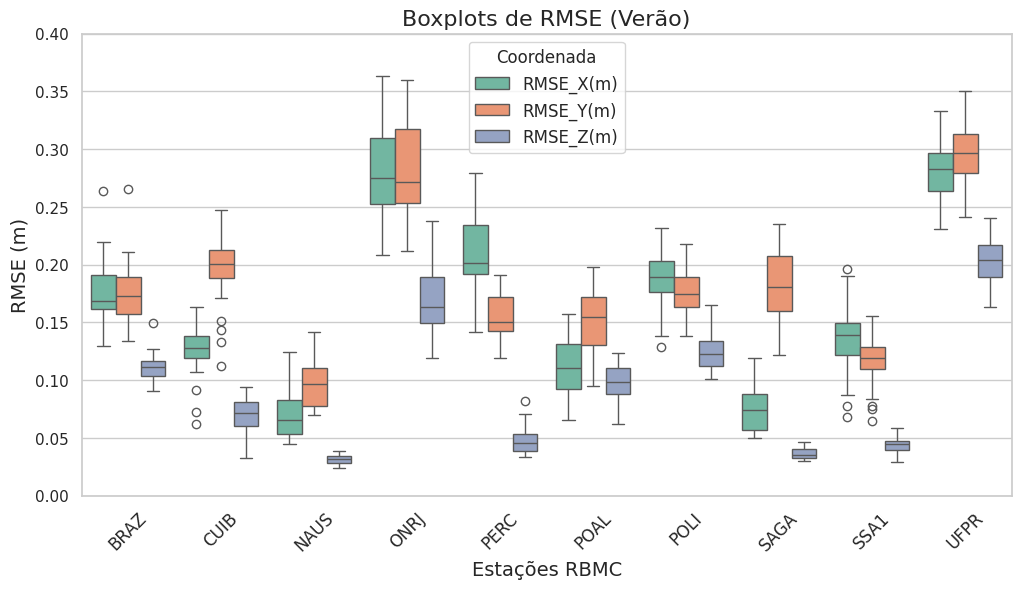

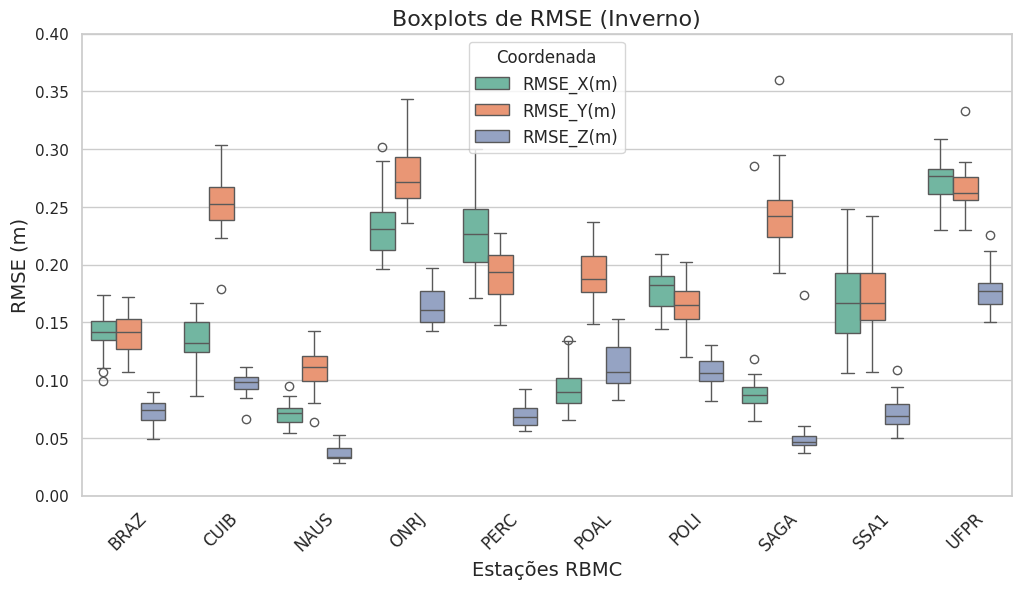

In [14]:
# Gera os boxplots para janeiro (verão) com limite máximo no eixo Y de 0.4
create_boxplot(df_verao, 'Verão', boxplot_verao_path.replace('.png','_v2.png'), ymax=0.4)

# Gera os boxplots para julho (inverno) com limite máximo no eixo Y de 0.4
create_boxplot(df_inverno, 'Inverno', boxplot_inverno_path.replace('.png','_v2.png'), ymax=0.4)


Histograma salvo em: charts/actual_vmf3_grads/rmse_histogram_janeiro_sem_outliers.png


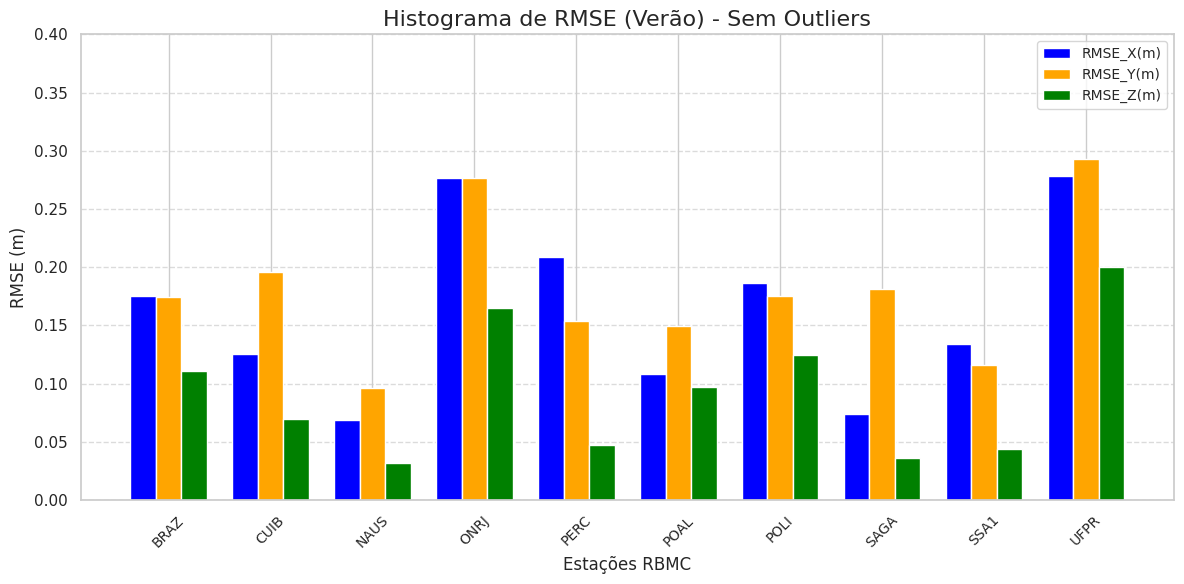

Histograma salvo em: charts/actual_vmf3_grads/rmse_histogram_julho_sem_outliers.png


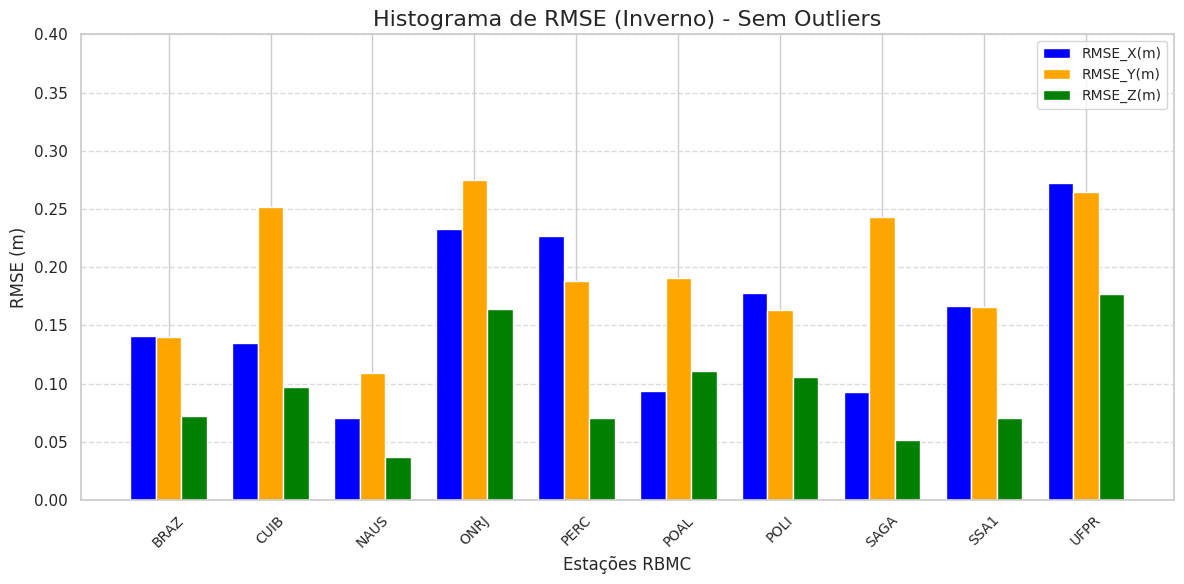

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Função para remover outliers
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Configurações para os histogramas
def plot_histograms(data, stations, rmse_x, rmse_y, rmse_z, title, save_path, y_max):
    # Define o índice das estações
    x = np.arange(len(stations))

    # Largura das colunas
    width = 0.25

    # Criação do gráfico
    fig, ax = plt.subplots(figsize=(12, 6))

    # Barras para cada RMSE
    ax.bar(x - width, rmse_x, width, label='RMSE_X(m)', color='blue')
    ax.bar(x, rmse_y, width, label='RMSE_Y(m)', color='orange')
    ax.bar(x + width, rmse_z, width, label='RMSE_Z(m)', color='green')

    # Configuração dos rótulos e título
    ax.set_xlabel('Estações RBMC', fontsize=12)
    ax.set_ylabel('RMSE (m)', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(stations, rotation=45, fontsize=10)
    ax.set_ylim(0, y_max)  # Define a escala fixa para o eixo Y
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajusta layout
    plt.tight_layout()

    # Salva a figura
    plt.savefig(save_path)
    print(f"Histograma salvo em: {save_path}")
    plt.show()

# Remove outliers para todas as colunas
data_clean = remove_outliers(df_results, 'RMSE_X')
data_clean = remove_outliers(data_clean, 'RMSE_Y')
data_clean = remove_outliers(data_clean, 'RMSE_Z')

# Filtra os dados para os períodos VERÃO (janeiro) e INVERNO (julho)
data_verao = data_clean[data_clean['Periodo'] == 'VERAO']
data_inverno = data_clean[data_clean['Periodo'] == 'INVERNO']

# Estações RBMC e valores RMSE para ambos os períodos
stations = data_clean['Estacao'].unique()
stations.sort()

rmse_verao_x = [data_verao[data_verao['Estacao'] == station]['RMSE_X'].mean() for station in stations]
rmse_verao_y = [data_verao[data_verao['Estacao'] == station]['RMSE_Y'].mean() for station in stations]
rmse_verao_z = [data_verao[data_verao['Estacao'] == station]['RMSE_Z'].mean() for station in stations]

rmse_inverno_x = [data_inverno[data_inverno['Estacao'] == station]['RMSE_X'].mean() for station in stations]
rmse_inverno_y = [data_inverno[data_inverno['Estacao'] == station]['RMSE_Y'].mean() for station in stations]
rmse_inverno_z = [data_inverno[data_inverno['Estacao'] == station]['RMSE_Z'].mean() for station in stations]

# Determina o limite máximo do eixo Y
y_max = max(
    max(rmse_verao_x + rmse_verao_y + rmse_verao_z),
    max(rmse_inverno_x + rmse_inverno_y + rmse_inverno_z),
) * 1.1  # Adiciona 10% de margem

# Gera o histograma para janeiro (VERÃO)
plot_histograms(
    data=data_verao,
    stations=stations,
    rmse_x=rmse_verao_x,
    rmse_y=rmse_verao_y,
    rmse_z=rmse_verao_z,
    title='Histograma de RMSE (Verão) - Sem Outliers',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_janeiro_Sem outliers.png',
    save_path = os.path.join(sc_charts_outpath,'rmse_histogram_janeiro_sem_outliers.png'),
    y_max=0.4 #y_max
)

# Gera o histograma para julho (INVERNO)
plot_histograms(
    data=data_inverno,
    stations=stations,
    rmse_x=rmse_inverno_x,
    rmse_y=rmse_inverno_y,
    rmse_z=rmse_inverno_z,
    title='Histograma de RMSE (Inverno) - Sem Outliers',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_julho_Sem outliers.png',
    save_path=os.path.join(sc_charts_outpath,'rmse_histogram_julho_sem_outliers.png'),
    y_max=0.4 #y_max
)
